In [ ]:
%pip install matplotlib
%pip install numpy

In [62]:
import numpy as np
from decayangle.lorentz import LorentzTrafo
from decayangle.decay_topology import Topology
from decayangle.config import config as cfg
import matplotlib.pyplot as plt
FONTSIZE_AXIS = 20
CMAP = "inferno"
# use tex for font rendering
plt.rc("font", family="serif", serif="Helvetica")
plt.rc("mathtext", fontset="dejavusans")
plt.rc("text", usetex=True)


def make_four_vectors(phi_rf, theta_rf, psi_rf):
    import numpy as np

    # Make sure, the sorting is turned off
    cfg.sorting = "off"

    # Given values
    # Lc -> p K pi
    m1, m2, m3, m0 = 0.93827, 0.493677, 0.139570, 2.28646
    m12 = 2.756020646168232**0.5
    m23 = 1.3743747462964881**0.5

    # Squared masses
    m0sq, m1sq, m2sq, m3sq, m12sq, m23sq = [x**2 for x in [m0, m1, m2, m3, m12, m23]]

    # Källén function
    def Kallen(x, y, z):
        return x**2 + y**2 + z**2 - 2 * (x * y + x * z + y * z)

    # Calculating missing mass squared using momentum conservation
    m31sq = m0sq + m1sq + m2sq + m3sq - m12sq - m23sq

    # Momenta magnitudes
    p1a = np.sqrt(Kallen(m23sq, m1sq, m0sq)) / (2 * m0)
    p2a = np.sqrt(Kallen(m31sq, m2sq, m0sq)) / (2 * m0)

    # Directions and components
    cos_zeta_12_for0_numerator = (m0sq + m1sq - m23sq) * (
        m0sq + m2sq - m31sq
    ) - 2 * m0sq * (m12sq - m1sq - m2sq)
    cos_zeta_12_for0_denominator = np.sqrt(Kallen(m0sq, m2sq, m31sq)) * np.sqrt(
        Kallen(m0sq, m23sq, m1sq)
    )
    cos_zeta_12_for0 = cos_zeta_12_for0_numerator / cos_zeta_12_for0_denominator

    p1z = -p1a
    p2z = -p2a * cos_zeta_12_for0
    p2x = np.sqrt(p2a**2 - p2z**2)
    p3z = -p2z - p1z
    p3x = -p2x

    # Energy calculations based on the relativistic energy-momentum relation
    E1 = np.sqrt(p1z**2 + m1sq)
    E2 = np.sqrt(p2z**2 + p2x**2 + m2sq)
    E3 = np.sqrt(p3z**2 + p3x**2 + m3sq)

    # Vectors
    p1 = np.array([0, 0, p1z, E1])
    p2 = np.array([p2x, 0, p2z, E2])
    p3 = np.array([p3x, 0, p3z, E3])

    # Lorentz transformation
    momenta = {i: p for i, p in zip([1, 2, 3], [p1, p2, p3])}
    tree1 = Topology(root=0, decay_topology=((2, 3), 1))
    
    rotation = LorentzTrafo(0, 0, 0, phi_rf, theta_rf, psi_rf)
    
    momenta_23_rotated = tree1.root.transform(rotation, momenta)
    return momenta_23_rotated

In [ ]:
def get_grid(phi,N=300, convention="helicity"):
    x_global = np.linspace(1e-5, np.pi - 1e-5, N)
    y_global = np.linspace(-np.pi + 1e-5, np.pi - 1e-5, N)

    X, Y = np.meshgrid(x_global, y_global)
    momenta_23_rotated = make_four_vectors(phi, X, Y)

    tree1 = Topology(root=0, decay_topology=((2, 3), 1))
    tree2 = Topology(root=0, decay_topology=((3, 1), 2))
    tree3 = Topology(root=0, decay_topology=((1, 2), 3))

    result_full = tree1.relative_wigner_angles(tree3, momenta_23_rotated, convention=convention)
    result_psi = result_full[1].psi_rf
    result_phi = result_full[1].phi_rf
    result_theta = result_full[1].theta_rf
    result = result_psi + result_phi

    return x_global, y_global, result, result_phi, result_theta, result_psi

x_global, y_global, result, result_phi, result_theta, result_psi = get_grid(1.4, convention="helicity", N=1000)



In [ ]:
def fmod_4(val):
    return np.fmod(val/np.pi + 4,4)

img = plt.imshow(fmod_4(result), cmap=CMAP, origin='lower',
                 extent=[x_global.min(), x_global.max(), y_global.min(), y_global.max()], aspect='auto')

plt.colorbar().set_label(r"$(\psi_{3(1)}^{1} + \phi_{3(1)}^{1})$ / $\pi$", fontsize=FONTSIZE_AXIS)
plt.xlabel(r'$\theta_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
plt.ylabel(r'$\psi_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
plt.xticks(np.linspace(0, np.pi, 8),fontsize=FONTSIZE_AXIS)
plt.yticks(np.linspace(-np.pi, np.pi, 9),fontsize=FONTSIZE_AXIS)
# plt.title(r"$\psi_{3}^{(1)}(1) + \phi_{3}^{(1)}(1)$")
plt.tight_layout()
plt.savefig('test.png', dpi = 800, bbox_inches='tight')

In [ ]:
img = plt.imshow(np.fmod(result_phi/np.pi +4, 4), cmap=CMAP, origin='lower',
                 extent=[x_global.min(), x_global.max(), y_global.min(), y_global.max()], aspect='auto')

plt.colorbar().set_label(r"$\phi_{3(1)}^{1}$ / $\pi$", fontsize=FONTSIZE_AXIS)
plt.xlabel(r'$\theta_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
plt.ylabel(r'$\psi_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
plt.xticks(np.linspace(0, np.pi, 8),fontsize=FONTSIZE_AXIS)
plt.yticks(np.linspace(-np.pi, np.pi, 9),fontsize=FONTSIZE_AXIS)
plt.tight_layout()
# plt.title(r"$\phi_{3}^{(1)}(1)$")
plt.savefig('test_phi.png', dpi = 800, bbox_inches='tight')

In [ ]:
img = plt.imshow(result_psi/np.pi, cmap=CMAP, origin='lower',
                 extent=[x_global.min(), x_global.max(), y_global.min(), y_global.max()], aspect='auto')

plt.colorbar().set_label(r"$\psi_{3(1)}^{1}$ / $\pi$", fontsize=FONTSIZE_AXIS)
plt.xlabel(r'$\theta_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
plt.ylabel(r'$\psi_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
plt.xticks(np.linspace(0, np.pi, 8),fontsize=FONTSIZE_AXIS)
plt.yticks(np.linspace(-np.pi, np.pi, 9),fontsize=FONTSIZE_AXIS)
plt.tight_layout()
# plt.title(r"$\psi_{3}^{(1)}(1)$")
plt.savefig('test_psi.png', dpi = 800, bbox_inches='tight')

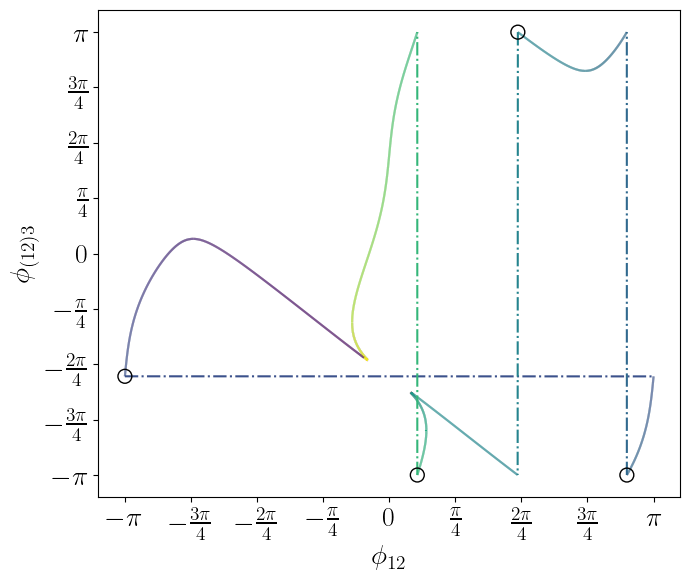

In [81]:
R = 1.5
PHI = 1.4
def plot_path(convention, include=1, color_info = False, cm=plt.cm.viridis, reference=True, phi=PHI):
    N = 15000
    t = np.linspace(-0.5,1.5,N)
    x = np.pi/2+ R*np.exp(1j*np.pi*t)

    t = np.linspace(0,1, N)
    theta, psi = np.real(x), 2*np.imag(x)
    momenta_23_rotated = make_four_vectors(phi, theta, psi)

    tree1 = Topology(root=0, decay_topology=((2, 3), 1))
    tree2 = Topology(root=0, decay_topology=((3, 1), 2))
    tree3 = Topology(root=0, decay_topology=((1, 2), 3))

    result_full1 = tree1.helicity_angles(momenta_23_rotated, convention=convention)
    result_full2 = tree2.helicity_angles(momenta_23_rotated, convention=convention)
    result_full3 = tree3.helicity_angles(momenta_23_rotated, convention=convention)

    result_full3.keys()
    plt.figure(figsize=(7, 5.9))
    # two subplots with equal size side by side
    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # ax1, ax2 = axs

    shift_mask = np.zeros_like(t, dtype=bool)
    def plot_color_segments(x,y, fmt=None, color=None, label=None,ax=plt, **kwargs):
        for i, (x_, y_, c) in enumerate(zip(x[:-1],y[:-1], color[:-1])):
            if fmt is not None:
                ax.plot([x_, x[i+1]], [y_, y[i+1]], fmt, color=c, zorder=1, **kwargs)
            else:
                ax.plot([x_, x[i+1]], [y_, y[i+1]], color=c, zorder=1, **kwargs)
        ax.plot(x[0], y[0], color=color[0], label=label)

    if reference:
        x_global, y_global, result, result_phi, result_theta, result_psi = get_grid(phi, 1000, convention=convention)
        img = plt.imshow(fmod_4(result_phi + result_psi), cmap=CMAP, origin='lower',
                 extent=[x_global.min(), x_global.max(), y_global.min(), y_global.max()], aspect=0.5)

        plt.xlabel(r'$\theta_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
        plt.ylabel(r'$\phi_{(23)1}$', fontdict={'fontsize': FONTSIZE_AXIS})
        plt.colorbar().set_label(r"$(\psi_{3(1)}^{1} + \phi_{3(1)}^{1})$ / $\pi$", fontsize=FONTSIZE_AXIS)
        labels = [r"$0$"] + [r"$\frac{\pi}{8}$"] + [r"$\frac{" +f"{i}" + r"\pi}{8}$" for i in range(2,8)] + [r"$\pi$"]
        plt.xticks(np.linspace(1.1e-5, np.pi-1.1e-5, 9), labels=labels,fontsize=FONTSIZE_AXIS)
        labels = [(r"$" + f"{'-' if i < 4 else ''}" + r"\frac{" +f"{abs(i - 4)}" + r"\pi}{4}$").replace("1", "") for i in range(9)]
        labels[4] = "0"
        labels[0] = r"$-\pi$"
        labels[-1] = r"$\pi$"
        plt.yticks(np.linspace(-np.pi+1.1e-5, np.pi-1.1e-5, 9), labels=labels,fontsize=FONTSIZE_AXIS)
        # plt.title(r"$(\psi_{3(1)}^{1} + \phi_{3(1)}^{1})$ / $\pi$")
        if color_info:
            plot_color_segments(theta, psi ,color=cm(t), ax=plt)
        else:
            plt.plot(theta, psi,"." ,color="black")

    
    if 1 == include:
        if not reference:
            if color_info:
                plot_color_segments(result_full1[((2, 3), 1)].phi_rf + t, result_full1[(2, 3)].phi_rf,  color=cm(t), label=r"$(\phi_1, \theta_1)$")
            else:
                plt.plot(result_full1[((2, 3), 1)].phi_rf, result_full1[((2, 3), 1)].theta_rf, "+", label=r"$(\phi_1, \theta_1)$", color="black")

    if 2 == include:
        if not reference:
            if color_info:
                plot_color_segments(result_full2[((3, 1), 2)].phi_rf, result_full2[(3, 1)].phi_rf, color=cm(t), label=r"$(\phi_2, \theta_2)")
            else:
                plt.plot(result_full2[((3, 1), 2)].phi_rf, result_full2[((3, 1), 2)].theta_rf, label=r"$(\psi_2, \theta_2)$", color="blue")

    if 3 == include:
        if color_info:
            diff = abs(result_full3[((1, 2), 3)].phi_rf[1:] - result_full3[((1, 2), 3)].phi_rf[:-1])
            shift_mask[:-1] = diff > np.pi

            diff = abs(result_full3[(1, 2)].phi_rf[1:] - result_full3[(1, 2)].phi_rf[:-1])
            shift_mask[:-1] = shift_mask[:-1] | (diff > np.pi)

            if not reference:
                plot_color_segments(result_full3[(1, 2)].phi_rf,result_full3[((1, 2), 3)].phi_rf,fmt="-.", color=cm(t), label=r"$(\phi_3, \psi_{12})$")
        else:
            if not reference:
                plt.plot(result_full3[((1, 2), 3)].theta_rf, result_full3[((1, 2), 3)].phi_rf, "--", label=r"$(\psi_3, \theta_3)$", color="red")
    
    daughter_dict = {1: "23", 2: "31", 3: "12"}
    y_label = r'$\phi_{' + f"({daughter_dict[include]}){include}" + r'}$'
    x_label = r'$\phi_{' + f"{daughter_dict[include]}" + r'}$'
    

    if not reference:
        plt.xlabel(x_label, fontdict={'fontsize': FONTSIZE_AXIS})
        plt.ylabel(y_label, fontdict={'fontsize': FONTSIZE_AXIS})
        labels = [(r"$" + f"{'-' if i < 4 else ''}" + r"\frac{" +f"{abs(i - 4)}" + r"\pi}{4}$").replace("1", "") for i in range(9)]
        labels[4] = "0"
        labels[0] = r"$-\pi$"
        labels[-1] = r"$\pi$"
        plt.xticks(np.linspace(-np.pi, np.pi, 9), labels=labels,fontsize=FONTSIZE_AXIS)
        plt.yticks(np.linspace(-np.pi, np.pi, 9), labels=labels,fontsize=FONTSIZE_AXIS)

    def update(t, label=""):
        x = np.pi/2+ R*np.exp(1j*np.pi*t)
        theta, psi = np.real(x), 2*np.imag(x)
        momenta_23_rotated = make_four_vectors(phi, theta, psi)
        tree1 = Topology(root=0, decay_topology=((2, 3), 1))
        tree2 = Topology(root=0, decay_topology=((3, 1), 2))
        tree3 = Topology(root=0, decay_topology=((1, 2), 3))
        result_full3 = tree3.helicity_angles(momenta_23_rotated, convention=convention)
        if reference:
            plt.scatter([theta],[psi], marker="o", s=100, zorder=10000, facecolors='none', edgecolors='white')
        else:
            plt.scatter( [result_full3[(1, 2)].phi_rf], [result_full3[((1, 2), 3)].phi_rf], marker="o", facecolors='none', edgecolors='black', s=100, zorder=10000)


    t = np.linspace(-0.5,1.5,N)[shift_mask]
    for i, t_ in enumerate(t):
        update(t_, label=f"t={t_:.2f}")
    return shift_mask

convention = "helicity"
shift_mask = plot_path(convention, include=3, color_info=True, phi=1.4, reference=False)
plt.tight_layout()
plt.savefig("path_helicity_1_4.png", dpi=800, bbox_inches='tight')
plt.show()

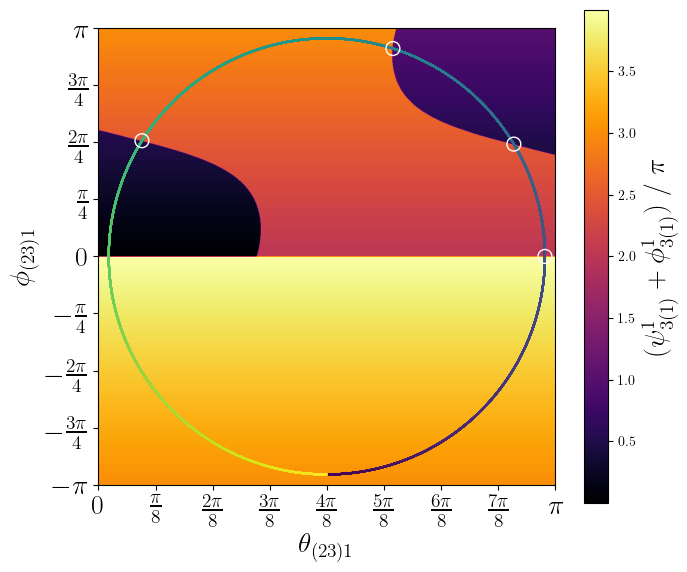

In [82]:
shift_mask = plot_path(convention, include=3, color_info=True, phi=1.4, reference=True)
plt.tight_layout()
plt.savefig("path_helicity_reference_1_4.png", dpi=800, bbox_inches='tight')
plt.show()

In [ ]:
_ = plot_path("minus_phi", include=3, color_info=True, phi=1.4, reference=False)
plt.savefig("path_minus_phi_1_4.png", dpi=800, bbox_inches='tight')
plt.show()

In [ ]:
_ = plot_path("canonical", include=3, color_info=True)